# HW 2 Problem 3 : Shades of NULL

#1. Import Libraries

In [1]:
#@markdown Install Libraries
!pip install virny
!git clone https://github.com/FalaahArifKhan/data-cleaning-stability.git
!mv /content/data-cleaning-stability /content/data_cleaning_stability

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.5 MB/s eta 0:00:00
Cloning into 'data-cleaning-stability'...
remote: Enumerating objects: 8730, done.
remote: Counting objects: 100% (865/865), done.
remote: Compressing objects: 100% (305/305), done.
remote: Total 8730 (delta 588), reused 573 (delta 560), pack-reused 7865 (from 2)
Receiving objects: 100% (8

In [2]:
#@markdown Import statments
import sys
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

import pandas as pd
import matplotlib.pyplot as plt
from virny.datasets import LawSchoolDataset
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio,
                               selection_rate_difference, false_negative_rate_difference,
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

sys.path.append('/content/data_cleaning_stability')
from source.error_injectors import nulls_injector

#2. Load Data

The Law school dataset (Wightman, 1998) was conducted by a Law School Admission Council (LSAC) survey across 163 law schools in the United States in 1991. The dataset contains the law school admission records. The prediction task is to predict whether a candidate would pass the bar exam or predict a student’s first-year average grade (FYA).

Dataset characteristics: The dataset contains information of 20,798 students characterized by 12 attributes (3 categorical, 3 binary and 6 numerical attributes).

For more information about the dataset, and if you are interested in other datasets, check this [paper](https://arxiv.org/pdf/2110.00530).

In [55]:
#@markdown Set Seeds
DATASET_SPLIT_SEED = 100
MODEL_SEED = 100
TEST_SET_FRACTION = 0.2

In [56]:
#@markdown Load Data
data_loader = LawSchoolDataset()
df = data_loader.full_df
df.head()

,decile1b,decile3,lsat,ugpa,zfygpa,zgpa,fulltime,fam_inc,male,tier,race,pass_bar
0,10.0,10.0,44.0,3.5,1.33,1.88,1,5,0,4,White,1
1,5.0,4.0,29.0,3.5,-0.11,-0.57,1,4,0,2,White,1
2,8.0,7.0,37.0,3.4,0.63,0.37,1,3,1,4,White,1
3,8.0,7.0,43.0,3.3,0.67,0.34,1,4,0,4,White,1
4,3.0,2.0,41.0,3.3,-0.67,-1.30,1,4,0,5,White,1


In [57]:
df.describe()

,decile1b,decile3,lsat,ugpa,zfygpa,zgpa,pass_bar
count,20798.000000,20798.000000,20798.000000,20798.000000,20798.000000,20798.000000,20798.000000
mean,5.562987,5.565054,36.762737,3.226810,0.097801,0.024189,0.889749
std,2.857880,2.857732,5.387053,0.411421,0.929575,0.988012,0.313210
min,1.000000,1.000000,11.000000,1.500000,-3.350000,-6.440000,0.000000
25%,3.000000,3.000000,33.000000,3.000000,-0.550000,-0.670000,1.000000
50%,6.000000,6.000000,37.000000,3.300000,0.090000,0.020000,1.000000
75%,8.000000,8.000000,41.000000,3.500000,0.750000,0.710000,1.000000
max,10.000000,10.000000,48.000000,4.000000,3.480000,4.010000,1.000000


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20798 entries, 0 to 20797
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   decile1b  20798 non-null  float64
 1   decile3   20798 non-null  float64
 2   lsat      20798 non-null  float64
 3   ugpa      20798 non-null  float64
 4   zfygpa    20798 non-null  float64
 5   zgpa      20798 non-null  float64
 6   fulltime  20798 non-null  object 
 7   fam_inc   20798 non-null  object 
 8   male      20798 non-null  object 
 9   tier      20798 non-null  object 
 10  race      20798 non-null  object 
 11  pass_bar  20798 non-null  int64  
dtypes: float64(6), int64(1), object(5)
memory usage: 1.9+ MB


In [59]:
unique_feature_values = df.apply(lambda col: col.unique())
unique_feature_values

,0
decile1b,"[10.0, 5.0, 8.0, 3.0, 1.0, 4.0, 2.0, 9.0, 7.0,..."
decile3,"[10.0, 4.0, 7.0, 2.0, 1.0, 3.0, 5.0, 9.0, 8.0,..."
lsat,"[44.0, 29.0, 37.0, 43.0, 41.0, 24.5, 34.0, 35...."
ugpa,"[3.5, 3.4, 3.3, 2.2, 3.2, 2.4, 2.9, 2.8, 3.9, ..."
zfygpa,"[1.33, -0.11, 0.63, 0.67, -0.67, -1.73, -0.32,..."
zgpa,"[1.88, -0.57, 0.37, 0.34, -1.3, -1.34, -0.38, ..."
fulltime,"[1, 2]"
fam_inc,"[5, 4, 3, 1, 2]"
male,"[0, 1]"
tier,"[4, 2, 5, 3, 1, 6]"


In [60]:
#@markdown Check for Categorical Variables
for col in data_loader.categorical_columns:
    print(f'{col}: {len(data_loader.full_df[col].unique())}')

fulltime: 2
fam_inc: 5
male: 2
tier: 6
race: 2


In [61]:
#@markdown Prediction Target
data_loader.target

'pass_bar'

In [10]:
temp = df[df['pass_bar'] == 0].shape[0]  # Count where pass_bar == 0
track = df[df['pass_bar'] == 1].shape[0]  # Count where pass_bar == 1
print(temp)
print(track)
print(df.shape)


2293
18505
(20798, 12)


## 3. Assess Fairness in the original data
In this section, we want to check the original proportions of the data, and also measure how a Random Forest Classifier performs in terms of fairness and accuracy.

In [11]:
#@markdown Race Proportions for bar passing
df.groupby('race')['pass_bar'].value_counts(normalize=True)

race       pass_bar
Non-White  1           0.723012
           0           0.276988
White      1           0.921274
           0           0.078726
Name: proportion, dtype: float64

In [12]:
#@markdown Functions for Fairness Metrics
# metrics for metricframe
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate,
           }

# fairness metric funciton as dataframe
def fairness_metrics(y_test, y_pred, sensitive_feature):
  fnr_diff = false_negative_rate_difference(y_test, y_pred, sensitive_features=sensitive_feature)
  fpr_diff = false_positive_rate_difference(y_test, y_pred, sensitive_features=sensitive_feature)
  demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_feature)
  equal_odds_ratio = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_feature)
  selec_rate_diff = selection_rate_difference(y_test, y_pred, sensitive_features=sensitive_feature)

  data = {'fnr_diff': [fnr_diff],
          'fpr_diff': [fpr_diff],
          'demo_parity_ratio': [demo_parity_ratio],
          'equal_odds_ratio': [equal_odds_ratio],
          'selec_rate_diff': [selec_rate_diff]
          }

  df = pd.DataFrame(data)

  return df

In [13]:
o_acc_drop=[]
o_prec_drop=[]
o_rec_drop=[]
o_fnr_drop=[]
o_fpr_drop=[]

o_acc_median=[]
o_prec_median=[]
o_rec_median=[]
o_fnr_median=[]
o_fpr_median=[]

In [14]:
acc_drop=[]
prec_drop=[]
rec_drop=[]
fnr_drop=[]
fpr_drop=[]

acc_median=[]
prec_median=[]
rec_median=[]
fnr_median=[]
fpr_median=[]

In [15]:
fnr_diff_drop=[]
fpr_diff_drop=[]
dpr_drop=[]
eor_drop=[]
srd_drop=[]

fnr_diff_median=[]
fpr_diff_median=[]
dpr_median=[]
eor_median=[]
srd_median=[]

In [16]:
#@markdown Function for data processing for Train/Eval
def prepare_data(df, test_size, seed):
  df = df.rename(columns={'race':'Non-White'})
  df['Non-White'] = df['Non-White'].replace({'White':0, 'Non-White':1})
  X = df.iloc[:,:-1]
  y = df[['pass_bar']]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(df, TEST_SET_FRACTION, DATASET_SPLIT_SEED)

In [17]:
#@markdown Run Prediction and output fairness metrics

rf = RandomForestClassifier(random_state=MODEL_SEED) # MODEL_SEED=100
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

race = X_test['Non-White']

groupby_race = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=race)


In [18]:
print("Initial Fairness:")
print('Fairness metrics for race')
print(groupby_race.by_group)
print('-'*80)
print(fairness_metrics(y_test, y_pred, race))

overall_drop_race=groupby_race.overall
o_acc_drop.append(("Default", overall_drop_race['accuracy']))
o_prec_drop.append(("Default", overall_drop_race['precision']))
o_rec_drop.append(("Default", overall_drop_race['recall']))
o_fnr_drop.append(("Default", overall_drop_race['FNR']))
o_fpr_drop.append(("Default", overall_drop_race['FPR']))

overall_median_race=groupby_race.overall
o_acc_median.append(("Default", overall_median_race['accuracy']))
o_prec_median.append(("Default", overall_median_race['precision']))
o_rec_median.append(("Default", overall_median_race['recall']))
o_fnr_median.append(("Default", overall_median_race['FNR']))
o_fpr_median.append(("Default", overall_median_race['FPR']))


group_drop_race=groupby_race.by_group

acc_drop.append(("Default", group_drop_race['accuracy']))
prec_drop.append(("Default", group_drop_race['precision']))
rec_drop.append(("Default", group_drop_race['recall']))
fnr_drop.append(("Default", group_drop_race['FNR']))
fpr_drop.append(("Default", group_drop_race['FPR']))

group_median_race=groupby_race.by_group
acc_median.append(("Defualt", group_median_race['accuracy']))
prec_median.append(("Default", group_median_race['precision']))
rec_median.append(("Default", group_median_race['recall']))
fnr_median.append(("Default", group_median_race['FNR']))
fpr_median.append(("Default", group_median_race['FPR']))


fair_drop_race=fairness_metrics(y_test, y_pred, race)

fnr_diff_drop.append(("Default", fair_drop_race['fnr_diff']))
fpr_diff_drop.append(("Default", fair_drop_race['fpr_diff']))
dpr_drop.append(("Default", fair_drop_race['demo_parity_ratio']))
eor_drop.append(("Default", fair_drop_race['equal_odds_ratio']))
srd_drop.append(("Default", fair_drop_race['selec_rate_diff']))

fair_median_race=fairness_metrics(y_test, y_pred, race)

fnr_diff_median.append(("Default", fair_median_race['fnr_diff']))
fpr_diff_median.append(("Default", fair_median_race['fpr_diff']))
dpr_median.append(("Default", fair_median_race['demo_parity_ratio']))
eor_median.append(("Default", fair_median_race['equal_odds_ratio']))
srd_median.append(("Default", fair_median_race['selec_rate_diff']))

print(groupby_race.overall)

Initial Fairness:
Fairness metrics for race
           accuracy  precision    recall       FNR       FPR
Non-White                                                   
0          0.922856   0.931226  0.989428  0.010572  0.867159
1          0.772660   0.819444  0.869474  0.130526  0.459596
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_ratio  equal_odds_ratio  selec_rate_diff
0  0.119954  0.407563           0.764227          0.530002          0.23104
accuracy     0.898558
precision    0.916858
recall       0.973991
FNR          0.026009
FPR          0.695096
dtype: float64


## 3. Simulate NULLs
Here, we will be using the following [Null Injector](https://github.com/FalaahArifKhan/data-cleaning-stability/blob/main/source/error_injectors/nulls_injector.py)

Make sure you go over the code above to properly simulate the nulls in the dataset.

### 3.1_a We start by simulating MCAR
Missing Completely at Random (MCAR). In law school dataset
with individual law school performance, MCAR holds if data is missing
due to administrative errors, unrelated to the any variables itself. That is: 𝑃(𝑅|𝑋)= 𝑃(𝑅)

In [19]:
#@markdown Inject MCAR Null values using nulls_injector

seed = 42
cols = ['decile1b', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa']
null_percentage = 0.5

mcar_injector = nulls_injector.NullsInjector(seed=seed,
                                             strategy='MCAR', # strategy should be from the list ['MCAR', 'MAR', 'MNAR']
                                             columns_with_nulls=cols,
                                             null_percentage=null_percentage)

mcar_df = data_loader.full_df.copy()
mcar_df = mcar_injector.fit_transform(mcar_df)
mcar_df.isnull().sum()

,0
decile1b,1730
decile3,1708
lsat,1678
ugpa,1815
zfygpa,1763
zgpa,1705
fulltime,0
fam_inc,0
male,0
tier,0


### 3.1_b How Null Handling changes the fairness for MCAR
We implement two methods of null handling, a median imputation and droping rows.

In [20]:
#@markdown functions to handle nulls

def impute_by_median(df, cols):
  df1 = df.copy()
  for col in cols:
    df1[col] = df1[col].fillna(df1[col].median())
  return df1

def delete_nulls(df):
  df1 = df.copy()
  df1 = df1.dropna()
  return df1

In [21]:
#@markdown handle nulls
mcar_df_drop_nulls = delete_nulls(mcar_df)
mcar_df_median_imputed = impute_by_median(mcar_df, cols)

In [22]:
#@markdown check for null counts
mcar_df_drop_nulls.isnull().sum()

,0
decile1b,0
decile3,0
lsat,0
ugpa,0
zfygpa,0
zgpa,0
fulltime,0
fam_inc,0
male,0
tier,0


In [23]:
#@markdown check for null counts
mcar_df_median_imputed.isnull().sum()

,0
decile1b,0
decile3,0
lsat,0
ugpa,0
zfygpa,0
zgpa,0
fulltime,0
fam_inc,0
male,0
tier,0


In [24]:
#@markdown Checking Fairness Metrics after null values handling (dropping nulls)

mcar_drop_X_train, mcar_drop_X_test, mcar_drop_y_train, mcar_drop_y_test = prepare_data(mcar_df_drop_nulls, TEST_SET_FRACTION, DATASET_SPLIT_SEED)
rf = RandomForestClassifier(random_state=MODEL_SEED)
rf.fit(mcar_drop_X_train, mcar_drop_y_train)
y_pred = rf.predict(mcar_drop_X_test)

race = mcar_drop_X_test['Non-White']
# gender = mcar_drop_X_test['male']

groupby_race = MetricFrame(metrics=metrics,
                           y_true=mcar_drop_y_test,
                           y_pred=y_pred,
                           sensitive_features=race)

# groupby_gender = MetricFrame(metrics=metrics,
#                            y_true=mcar_drop_y_test,
#                            y_pred=y_pred,
#                            sensitive_features=gender)

print('Fairness metrics for race - MCAR drop nulls')
print('-'*80)
print(groupby_race.by_group)
print('-'*80)
print(fairness_metrics(mcar_drop_y_test, y_pred, race))
print('-'*80)

overall_drop_race=groupby_race.overall
o_acc_drop.append(("MCAR_drop", overall_drop_race['accuracy']))
o_prec_drop.append(("MCAR_drop", overall_drop_race['precision']))
o_rec_drop.append(("MCAR_drop", overall_drop_race['recall']))
o_fnr_drop.append(("MCAR_drop", overall_drop_race['FNR']))
o_fpr_drop.append(("MCAR_drop", overall_drop_race['FPR']))

group_drop_race=groupby_race.by_group
acc_drop.append(("MCAR_drop", group_drop_race['accuracy']))
prec_drop.append(("MCAR_drop", group_drop_race['precision']))
rec_drop.append(("MCAR_drop", group_drop_race['recall']))
fnr_drop.append(("MCAR_drop", group_drop_race['FNR']))
fpr_drop.append(("MCAR_drop", group_drop_race['FPR']))

fair_drop_race=fairness_metrics(mcar_drop_y_test, y_pred, race)

fnr_diff_drop.append(("MCAR_drop", fair_drop_race['fnr_diff']))
fpr_diff_drop.append(("MCAR_drop", fair_drop_race['fpr_diff']))
dpr_drop.append(("MCAR_drop", fair_drop_race['demo_parity_ratio']))
eor_drop.append(("MCAR_drop", fair_drop_race['equal_odds_ratio']))
srd_drop.append(("MCAR_drop", fair_drop_race['selec_rate_diff']))

# print('Fairness metrics for gender - MCAR median Imputed')
# print(groupby_gender.by_group)
# print('-'*80)
# print(fairness_metrics(mcar_median_y_test, y_pred, gender))

Fairness metrics for race - MCAR drop nulls
--------------------------------------------------------------------------------
           accuracy  precision    recall       FNR       FPR
Non-White                                                   
0          0.915621   0.934388  0.977928  0.022072  0.910569
1          0.760736   0.825911  0.853556  0.146444  0.494253
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_ratio  equal_odds_ratio  selec_rate_diff
0  0.124371  0.416316            0.77853          0.542796         0.215535
--------------------------------------------------------------------------------


In [25]:
#@markdown Checking Fairness Metrics after null values handling (median impudation)
mcar_median_X_train, mcar_median_X_test, mcar_median_y_train, mcar_median_y_test = prepare_data(mcar_df_median_imputed, TEST_SET_FRACTION, DATASET_SPLIT_SEED)
rf = RandomForestClassifier(random_state=MODEL_SEED)
rf.fit(mcar_median_X_train, mcar_median_y_train)
y_pred = rf.predict(mcar_median_X_test)

race = mcar_median_X_test['Non-White']
gender = mcar_median_X_test['male']


groupby_race = MetricFrame(metrics=metrics,
                           y_true=mcar_median_y_test,
                           y_pred=y_pred,
                           sensitive_features=race)

groupby_gender = MetricFrame(metrics=metrics,
                           y_true=mcar_median_y_test,
                           y_pred=y_pred,
                           sensitive_features=gender)

print('Fairness metrics for race - MCAR median Imputed')
print(groupby_race.by_group)
print('-'*80)
print(fairness_metrics(mcar_median_y_test, y_pred, race))
print('-'*80)

overall_median_race=groupby_race.overall
o_acc_median.append(("MCAR_median", overall_median_race['accuracy']))
o_prec_median.append(("MCAR_median", overall_median_race['precision']))
o_rec_median.append(("MCAR_median", overall_median_race['recall']))
o_fnr_median.append(("MCAR_median", overall_median_race['FNR']))
o_fpr_median.append(("MCAR_median", overall_median_race['FPR']))

group_median_race=groupby_race.by_group
acc_median.append(("MCAR_median", group_median_race['accuracy']))
prec_median.append(("MCAR_median", group_median_race['precision']))
rec_median.append(("MCAR_median", group_median_race['recall']))
fnr_median.append(("MCAR_median", group_median_race['FNR']))
fpr_median.append(("MCAR_median", group_median_race['FPR']))

fair_median_race=fairness_metrics(mcar_median_y_test, y_pred, race)
fnr_diff_median.append(("MCAR_median", fair_median_race['fnr_diff']))
fpr_diff_median.append(("MCAR_median", fair_median_race['fpr_diff']))
dpr_median.append(("MCAR_median", fair_median_race['demo_parity_ratio']))
eor_median.append(("MCAR_median", fair_median_race['equal_odds_ratio']))
srd_median.append(("MCAR_median", fair_median_race['selec_rate_diff']))

# print('Fairness metrics for gender - MCAR median Imputed')
# print(groupby_gender.by_group)
# print('-'*80)
# print(fairness_metrics(mcar_median_y_test, y_pred, gender))

Fairness metrics for race - MCAR median Imputed
           accuracy  precision    recall       FNR       FPR
Non-White                                                   
0          0.925724   0.931175  0.992848  0.007152  0.870849
1          0.759287   0.811133  0.858947  0.141053  0.479798
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_ratio  equal_odds_ratio  selec_rate_diff
0  0.133901  0.391051           0.760042          0.550954         0.235967
--------------------------------------------------------------------------------


### 3.2_a Simulating MAR
Missing at Random (MAR). If the disadvantaged group are more likely to withhold their law school performance, and this can be explained by observed covariates (i.e., race), then MAR holds. Here, missingness depends only on observed features, not the missing values themselves: 𝑃(𝑅|𝑋)= 𝑃(𝑅|𝑋obs).

In [26]:
#@markdown TODO: inject MAR conditioned on Non-white students
#@markdown Hint: add a condition input to NullsInjector. condition has to be tuple of conditions, like ('col_name', value)
#@markdown Inject MAR Null values using nulls_injector

seed = 42
cols = ['zfygpa', 'zgpa']
null_percentage = 0.5

mar_df = data_loader.full_df.copy()

mar_injector = nulls_injector.NullsInjector(seed=seed,
                                             strategy='MAR', # strategy should be from the list ['MCAR', 'MAR', 'MNAR']
                                             columns_with_nulls=cols,
                                             null_percentage=null_percentage,
                                             condition=('race','Non-White'))

mar_df = mar_injector.fit_transform(mar_df)
# mar_df.isnull().sum()





### 3.2_b How Null Handling changes the fairness for MAR
We implement two methods of null handling, a median imputation and droping rows.



In [27]:
#TODO: handle null values
mar_df_drop_nulls = delete_nulls(mar_df)
mar_df_median_imputed = impute_by_median(mar_df, cols)

In [85]:
mar_df_drop_nulls.isnull().sum()

,0
decile1b,0
decile3,0
lsat,0
ugpa,0
zfygpa,0
zgpa,0
fulltime,0
fam_inc,0
male,0
tier,0


In [86]:
mar_df_median_imputed.isnull().sum()

,0
decile1b,0
decile3,0
lsat,0
ugpa,0
zfygpa,0
zgpa,0
fulltime,0
fam_inc,0
male,0
tier,0


In [87]:
#@markdown Checking Fairness Metrics after null values handling (dropping nulls)
#TODO: run a prediction and fairness metric evaluation for dropping rows

mar_drop_X_train, mar_drop_X_test, mar_drop_y_train, mar_drop_y_test = prepare_data(mar_df_drop_nulls, TEST_SET_FRACTION, DATASET_SPLIT_SEED)
rf = RandomForestClassifier(random_state=MODEL_SEED)
rf.fit(mar_drop_X_train, mar_drop_y_train)
y_pred = rf.predict(mar_drop_X_test)

race = mar_drop_X_test['Non-White']

groupby_race = MetricFrame(metrics=metrics,
                           y_true=mar_drop_y_test,
                           y_pred=y_pred,
                           sensitive_features=race)

print('Fairness metrics for race - MAR drop nulls')
print('-'*80)
print(groupby_race.by_group)
print('-'*80)
print(fairness_metrics(mar_drop_y_test, y_pred, race))

overall_drop_race=groupby_race.overall
o_acc_drop.append(("MAR_drop", overall_drop_race['accuracy']))
o_prec_drop.append(("MAR_drop", overall_drop_race['precision']))
o_rec_drop.append(("MAR_drop", overall_drop_race['recall']))
o_fnr_drop.append(("MAR_drop", overall_drop_race['FNR']))
o_fpr_drop.append(("MAR_drop", overall_drop_race['FPR']))

group_drop_race=groupby_race.by_group
acc_drop.append(("MAR_drop", group_drop_race['accuracy']))
prec_drop.append(("MAR_drop", group_drop_race['precision']))
rec_drop.append(("MAR_drop", group_drop_race['recall']))
fnr_drop.append(("MAR_drop", group_drop_race['FNR']))
fpr_drop.append(("MAR_drop", group_drop_race['FPR']))

fair_drop_race=fairness_metrics(mar_drop_y_test, y_pred, race)

fnr_diff_drop.append(("MAR_drop", fair_drop_race['fnr_diff']))
fpr_diff_drop.append(("MAR_drop", fair_drop_race['fpr_diff']))
dpr_drop.append(("MAR_drop", fair_drop_race['demo_parity_ratio']))
eor_drop.append(("MAR_drop", fair_drop_race['equal_odds_ratio']))
srd_drop.append(("MAR_drop", fair_drop_race['selec_rate_diff']))

Fairness metrics for race - MAR drop nulls
--------------------------------------------------------------------------------
           accuracy  precision    recall       FNR       FPR
Non-White                                                   
0          0.918525   0.930873  0.984816  0.015184  0.870849
1          0.764350   0.818930  0.854077  0.145923  0.448980
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_ratio  equal_odds_ratio  selec_rate_diff
0  0.130738  0.421869           0.752202          0.515566         0.241847


In [88]:
#@markdown Checking Fairness Metrics after null values handling (median impudation)
#TODO: run a prediction and fairness metric evaluation for median imputation

mar_median_X_train, mar_median_X_test, mar_median_y_train, mar_median_y_test = prepare_data(mar_df_median_imputed, TEST_SET_FRACTION, DATASET_SPLIT_SEED)
rf = RandomForestClassifier(random_state=MODEL_SEED)
rf.fit(mar_median_X_train, mar_median_y_train)
y_pred = rf.predict(mar_median_X_test)

race = mar_median_X_test['Non-White']
gender = mar_median_X_test['male']


groupby_race = MetricFrame(metrics=metrics,
                           y_true=mar_median_y_test,
                           y_pred=y_pred,
                           sensitive_features=race)

groupby_gender = MetricFrame(metrics=metrics,
                           y_true=mar_median_y_test,
                           y_pred=y_pred,
                           sensitive_features=gender)


print('Fairness metrics for race - MCAR median Imputed')
print(groupby_race.by_group)
print('-'*80)
print(fairness_metrics(mar_median_y_test, y_pred, race))

overall_median_race=groupby_race.overall
o_acc_median.append(("MAR_median", overall_median_race['accuracy']))
o_prec_median.append(("MAR_median", overall_median_race['precision']))
o_rec_median.append(("MAR_median", overall_median_race['recall']))
o_fnr_median.append(("MAR_median", overall_median_race['FNR']))
o_fpr_median.append(("MAR_median", overall_median_race['FPR']))

group_median_race=groupby_race.by_group
acc_median.append(("MAR_median", group_median_race['accuracy']))
prec_median.append(("MAR_median", group_median_race['precision']))
rec_median.append(("MAR_median", group_median_race['recall']))
fnr_median.append(("MAR_median", group_median_race['FNR']))
fpr_median.append(("MAR_median", group_median_race['FPR']))

fair_median_race=fairness_metrics(mar_median_y_test, y_pred, race)
fnr_diff_median.append(("MAR_median", fair_median_race['fnr_diff']))
fpr_diff_median.append(("MAR_median", fair_median_race['fpr_diff']))
dpr_median.append(("MAR_median", fair_median_race['demo_parity_ratio']))
eor_median.append(("MAR_median", fair_median_race['equal_odds_ratio']))
srd_median.append(("MAR_median", fair_median_race['selec_rate_diff']))

print('-'*80)

print('Fairness metrics for gender - MCAR median Imputed')
print(groupby_gender.by_group)
print('-'*80)
print(fairness_metrics(mar_median_y_test, y_pred, gender))

Fairness metrics for race - MCAR median Imputed
           accuracy  precision    recall       FNR       FPR
Non-White                                                   
0          0.922856   0.931985  0.988495  0.011505  0.856089
1          0.765230   0.820202  0.854737  0.145263  0.449495
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_ratio  equal_odds_ratio  selec_rate_diff
0  0.133758  0.406594             0.7519          0.525057         0.242692
--------------------------------------------------------------------------------
Fairness metrics for gender - MCAR median Imputed
      accuracy  precision    recall       FNR       FPR
male                                                   
0     0.892667   0.911313  0.972104  0.027896  0.669528
1     0.901229   0.923149  0.970617  0.029383  0.699153
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_rati

### 3.3_a Simulating Missing not at Random
Missing Not at Random (MNAR). Consider a student whose
academic performance depends by different law schools (i.e. different schools have different grading standards)—not captured in the data—rather than by race. Suppose students with lower academic performance are more likely to withhold this information. In this case, MNAR holds because missingness is correlated with the missing value itself and can not be explained by observed covariates (i.e., race): 𝑃(𝑅|𝑋) ≠ 𝑃(𝑅|𝑋obs)

In [32]:
#@markdown TODO: select columns you want to simulate MNAR, and simulate MNAR.
#@markdown hint: condition value has to be a conditional statement, like (col, {'lt': col.median()}).
#@markdown Options for condition are 'ge'(greater or eqal to), 'gt'(greater than), 'le' (less or equal to), 'lt'(less than))

mnar_df = data_loader.full_df.copy()
seed = 42
cols = ['zfygpa', 'zgpa']
null_percentage = 0.5
# i=0
# mnar_injector=[]

for col in cols:
  mnar_injector=nulls_injector.NullsInjector(seed=seed,
                                             strategy='MNAR', # strategy should be from the list ['MCAR', 'MAR', 'MNAR']
                                             columns_with_nulls=[col],
                                             null_percentage=null_percentage,
                                             condition=(col,{'lt': mnar_df[col].median()}))

  mnar_df = mnar_injector.fit_transform(mnar_df)
  mnar_df.isnull().sum()
  # i+=1

### 3.3_b How Null Handling changes the fairness for MNAR
We implement two methods of null handling, a median imputation and droping rows.



In [33]:
#@TODO: handle null values
# mnar_df_drop_nulls=[]
# mnar_df_median_imputed=[]
# i=0

# for col in cols:
mnar_df_drop_nulls=delete_nulls(mnar_df)
mnar_df_median_imputed=impute_by_median(mnar_df, cols)
  # i+=1

In [78]:
mnar_df_drop_nulls.isnull().sum()

,0
decile1b,0
decile3,0
lsat,0
ugpa,0
zfygpa,0
zgpa,0
fulltime,0
fam_inc,0
male,0
tier,0


In [80]:
# mnar_df_drop_nulls[1].isnull().sum()

In [84]:
mnar_df_median_imputed.isnull().sum()

,0
decile1b,0
decile3,0
lsat,0
ugpa,0
zfygpa,0
zgpa,0
fulltime,0
fam_inc,0
male,0
tier,0


In [82]:
# mnar_df_drop_nulls[1].isnull().sum()

In [38]:
#@TODO: run a prediction and fairness metric evaluation for dropping values
mnar_drop_X_train, mnar_drop_X_test, mnar_drop_y_train, mnar_drop_y_test = prepare_data(mnar_df_drop_nulls, TEST_SET_FRACTION, DATASET_SPLIT_SEED)
rf = RandomForestClassifier(random_state=MODEL_SEED)
rf.fit(mnar_drop_X_train, mnar_drop_y_train)
y_pred = rf.predict(mnar_drop_X_test)

race = mnar_drop_X_test['Non-White']

groupby_race = MetricFrame(metrics=metrics,
                           y_true=mnar_drop_y_test,
                           y_pred=y_pred,
                           sensitive_features=race)

print('Fairness metrics for race - MNAR drop nulls')
print('-'*80)
print(groupby_race.by_group)
print('-'*80)
print(fairness_metrics(mnar_drop_y_test, y_pred, race))

overall_drop_race=groupby_race.overall
o_acc_drop.append(("MNAR_drop", overall_drop_race['accuracy']))
o_prec_drop.append(("MNAR_drop", overall_drop_race['precision']))
o_rec_drop.append(("MNAR_drop", overall_drop_race['recall']))
o_fnr_drop.append(("MNAR_drop", overall_drop_race['FNR']))
o_fpr_drop.append(("MNAR_drop", overall_drop_race['FPR']))

group_drop_race=groupby_race.by_group
acc_drop.append(("MNAR_drop", group_drop_race['accuracy']))
prec_drop.append(("MNAR_drop", group_drop_race['precision']))
rec_drop.append(("MNAR_drop", group_drop_race['recall']))
fnr_drop.append(("MNAR_drop", group_drop_race['FNR']))
fpr_drop.append(("MNAR_drop", group_drop_race['FPR']))

fair_drop_race=fairness_metrics(mnar_drop_y_test, y_pred, race)

fnr_diff_drop.append(("MNAR_drop", fair_drop_race['fnr_diff']))
fpr_diff_drop.append(("MNAR_drop", fair_drop_race['fpr_diff']))
dpr_drop.append(("MNAR_drop", fair_drop_race['demo_parity_ratio']))
eor_drop.append(("MNAR_drop", fair_drop_race['equal_odds_ratio']))
srd_drop.append(("MNAR_drop", fair_drop_race['selec_rate_diff']))

Fairness metrics for race - MNAR drop nulls
--------------------------------------------------------------------------------
           accuracy  precision    recall       FNR       FPR
Non-White                                                   
0          0.956502   0.963282  0.992527  0.007473  0.910112
1          0.863787   0.899225  0.939271  0.060729  0.481481
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_ratio  equal_odds_ratio  selec_rate_diff
0  0.053256  0.428631           0.866468          0.529035         0.132095


In [39]:
#@TODO: run a prediction and fairness metric evaluation for median imputation
#@markdown Checking Fairness Metrics after null values handling (median impudation)
mnar_median_X_train, mnar_median_X_test, mnar_median_y_train, mnar_median_y_test = prepare_data(mnar_df_median_imputed, TEST_SET_FRACTION, DATASET_SPLIT_SEED)
rf = RandomForestClassifier(random_state=MODEL_SEED)
rf.fit(mnar_median_X_train, mnar_median_y_train)
y_pred = rf.predict(mnar_median_X_test)

race = mnar_median_X_test['Non-White']
gender = mnar_median_X_test['male']


groupby_race = MetricFrame(metrics=metrics,
                           y_true=mnar_median_y_test,
                           y_pred=y_pred,
                           sensitive_features=race)

groupby_gender = MetricFrame(metrics=metrics,
                           y_true=mnar_median_y_test,
                           y_pred=y_pred,
                           sensitive_features=gender)


print('Fairness metrics for race - MNAR median Imputed')
print(groupby_race.by_group)
print('-'*80)
print(fairness_metrics(mnar_median_y_test, y_pred, race))

overall_median_race=groupby_race.overall
o_acc_median.append(("MNAR_median", overall_median_race['accuracy']))
o_prec_median.append(("MNAR_median", overall_median_race['precision']))
o_rec_median.append(("MNAR_median", overall_median_race['recall']))
o_fnr_median.append(("MNAR_median", overall_median_race['FNR']))
o_fpr_median.append(("MNAR_median", overall_median_race['FPR']))

group_median_race=groupby_race.by_group
acc_median.append(("MNAR_median", group_median_race['accuracy']))
prec_median.append(("MNAR_median", group_median_race['precision']))
rec_median.append(("MNAR_median", group_median_race['recall']))
fnr_median.append(("MNAR_median", group_median_race['FNR']))
fpr_median.append(("MNAR_median", group_median_race['FPR']))

fair_median_race=fairness_metrics(mnar_median_y_test, y_pred, race)
fnr_diff_median.append(("MNAR_median", fair_median_race['fnr_diff']))
fpr_diff_median.append(("MNAR_median", fair_median_race['fpr_diff']))
dpr_median.append(("MNAR_median", fair_median_race['demo_parity_ratio']))
eor_median.append(("MNAR_median", fair_median_race['equal_odds_ratio']))
srd_median.append(("MNAR_median", fair_median_race['selec_rate_diff']))


print('-'*80)

print('Fairness metrics for gender - MNAR median Imputed')
print(groupby_gender.by_group)
print('-'*80)
print(fairness_metrics(mnar_median_y_test, y_pred, gender))

Fairness metrics for race - MNAR median Imputed
           accuracy  precision    recall       FNR       FPR
Non-White                                                   
0          0.918841   0.929429  0.986940  0.013060  0.889299
1          0.757801   0.805882  0.865263  0.134737  0.500000
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_ratio  equal_odds_ratio  selec_rate_diff
0  0.121677  0.389299           0.773778          0.562241         0.221551
--------------------------------------------------------------------------------
Fairness metrics for gender - MNAR median Imputed
      accuracy  precision    recall       FNR       FPR
male                                                   
0     0.880446   0.904086  0.966040  0.033960  0.725322
1     0.902985   0.920943  0.975514  0.024486  0.724576
--------------------------------------------------------------------------------
   fnr_diff  fpr_diff  demo_parity_rati

In [40]:
import seaborn as sns

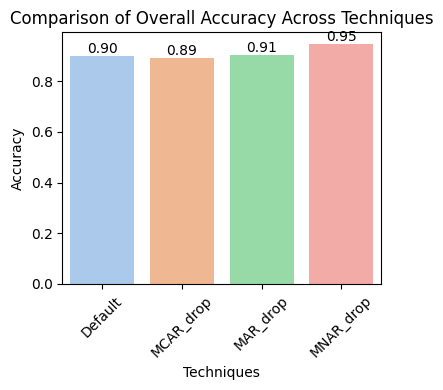

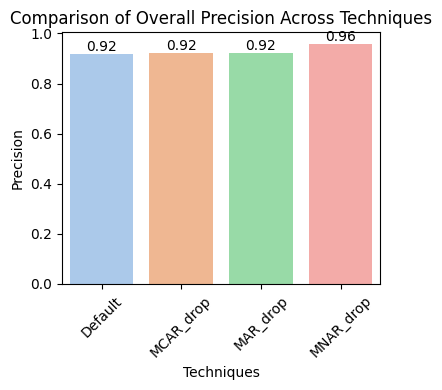

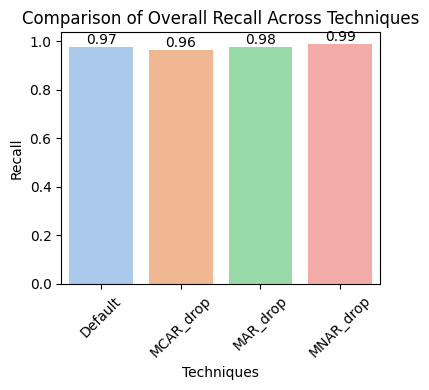

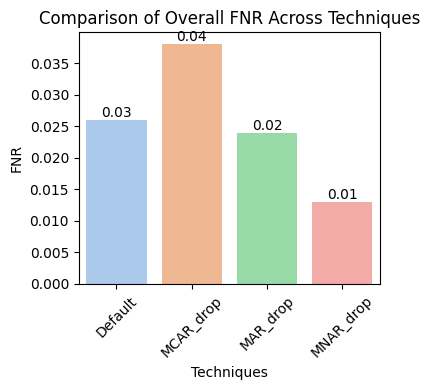

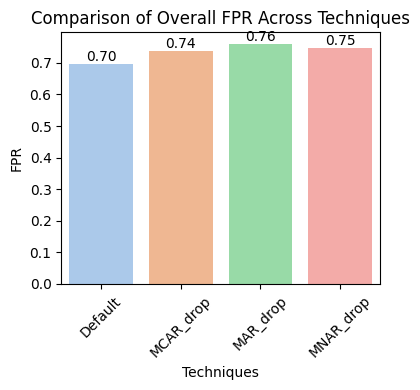

In [41]:
##DROP NULLS OVERALL
dataframes = [o_acc_drop,o_prec_drop,o_rec_drop,o_fnr_drop,o_fpr_drop]
names=["Accuracy", "Precision", "Recall", "FNR", "FPR"]

# Function to create bar plots for a given metric
def plot_metric(data, metric_name):
    plt.figure(figsize=(4, 4))
    ax = sns.barplot(x="Technique", y=data.columns[1], data=data, palette="pastel")

    # Add values above the bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x-coordinate (center of bar)
            p.get_height(),         # y-coordinate (slightly above the bar)
            f'{p.get_height():.2f}',       # Value to display (formatted to 2 decimal places)
            ha="center",                   # Horizontal alignment
            va="bottom",                   # Vertical alignment
            fontsize=10                    # Font size of the annotation
        )

    plt.title(f"Comparison of Overall {metric_name} Across Techniques")
    plt.xlabel("Techniques")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


i=0
for j in dataframes:
  j=pd.DataFrame(j, columns=["Technique", names[i]])
  metric_name = j.columns[1]  # Second column holds metric values
  j[metric_name] = j[metric_name].apply(lambda x: float(x.iloc[0]) if hasattr(x, 'iloc') else float(x))
  plot_metric(j,names[i])
  i+=1




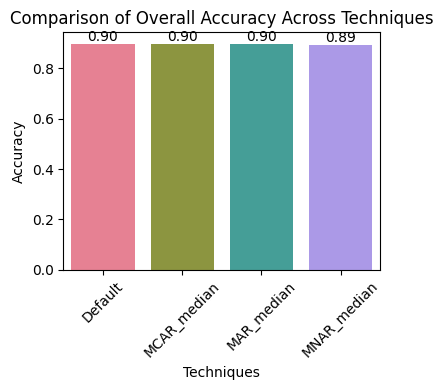

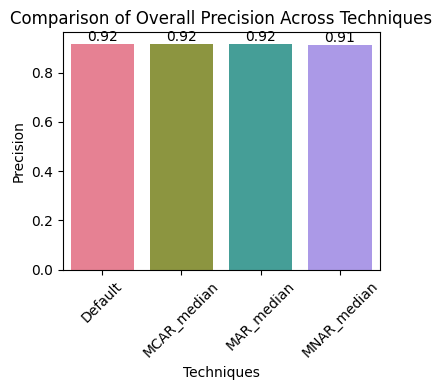

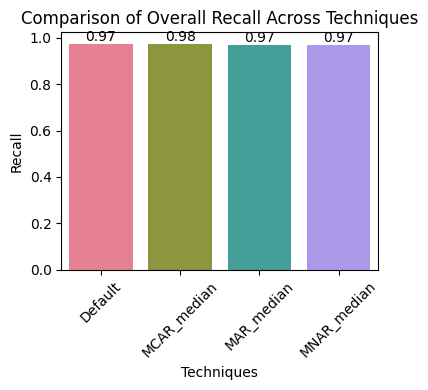

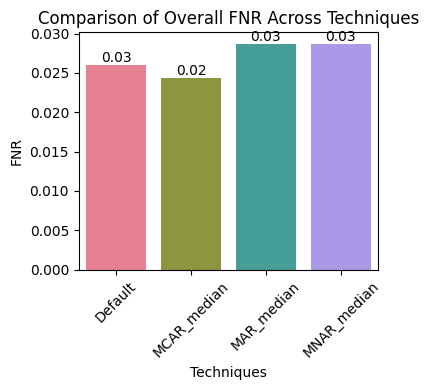

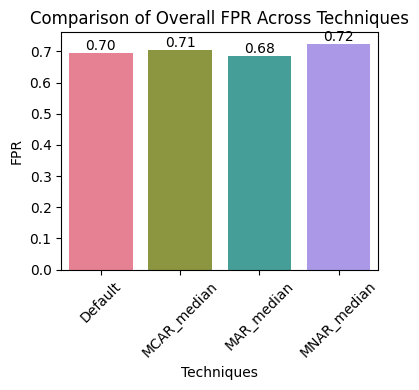

In [42]:
##MEDIAN OVERALL
dataframes = [o_acc_median,o_prec_median,o_rec_median,o_fnr_median,o_fpr_median]
names=["Accuracy", "Precision", "Recall", "FNR", "FPR"]

# Function to create bar plots for a given metric
def plot_metric(data, metric_name):
    plt.figure(figsize=(4, 4))
    ax = sns.barplot(x="Technique", y=data.columns[1], data=data, palette="husl")

    # Add values above the bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x-coordinate (center of bar)
            p.get_height(),         # y-coordinate (slightly above the bar)
            f'{p.get_height():.2f}',       # Value to display (formatted to 2 decimal places)
            ha="center",                   # Horizontal alignment
            va="bottom",                   # Vertical alignment
            fontsize=10                    # Font size of the annotation
        )

    plt.title(f"Comparison of Overall {metric_name} Across Techniques")
    plt.xlabel("Techniques")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

i=0
for j in dataframes:
  j=pd.DataFrame(j, columns=["Technique", names[i]])
  metric_name = j.columns[1]  # Second column holds metric values
  j[metric_name] = j[metric_name].apply(lambda x: float(x.iloc[0]) if hasattr(x, 'iloc') else float(x))
  plot_metric(j,names[i])
  i+=1


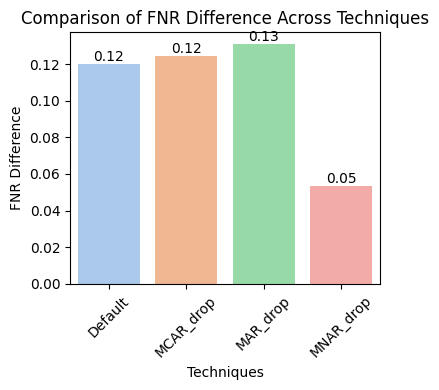

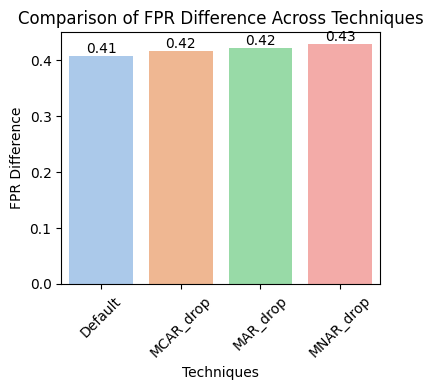

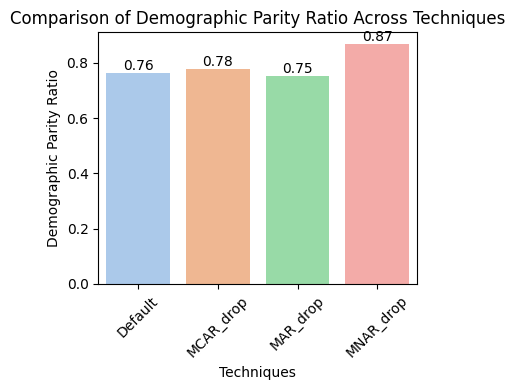

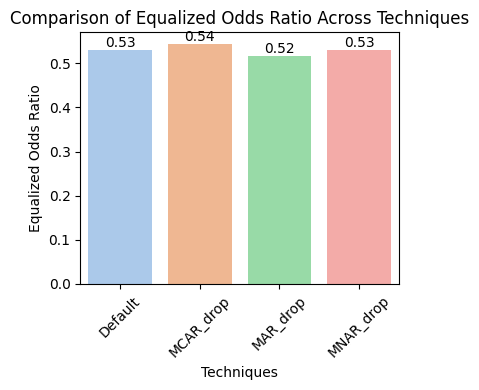

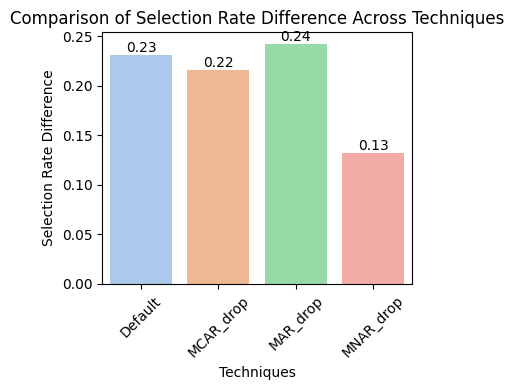

In [43]:
##DROP NULLS FAIRNESS
# Combine data for each metric
fnr_diff_data = pd.DataFrame(fnr_diff_drop, columns=["Technique", "FNR Difference"])
fpr_diff_data = pd.DataFrame(fpr_diff_drop, columns=["Technique", "FPR Difference"])
dpr_data = pd.DataFrame(dpr_drop, columns=["Technique", "Demographic Parity Ratio"])
eor_data = pd.DataFrame(eor_drop, columns=["Technique", "Equalized Odds Ratio"])
srd_data = pd.DataFrame(srd_drop, columns=["Technique", "Selection Rate Difference"])

dataframes = [fnr_diff_data, fpr_diff_data, dpr_data, eor_data, srd_data]
for df in dataframes:
    metric_name = df.columns[1]  # Second column holds metric values
    df[metric_name] = df[metric_name].apply(lambda x: float(x.iloc[0]) if hasattr(x, 'iloc') else float(x))


# Function to create bar plots for a given metric
def plot_metric(data, metric_name):
    plt.figure(figsize=(4, 4))
    ax = sns.barplot(x="Technique", y=data.columns[1], data=data, palette="pastel")

    # Add values above the bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x-coordinate (center of bar)
            p.get_height(),         # y-coordinate (slightly above the bar)
            f'{p.get_height():.2f}',       # Value to display (formatted to 2 decimal places)
            ha="center",                   # Horizontal alignment
            va="bottom",                   # Vertical alignment
            fontsize=10                    # Font size of the annotation
        )

    plt.title(f"Comparison of {metric_name} Across Techniques")
    plt.xlabel("Techniques")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot all metrics
plot_metric(fnr_diff_data, "FNR Difference")
plot_metric(fpr_diff_data, "FPR Difference")
plot_metric(dpr_data, "Demographic Parity Ratio")
plot_metric(eor_data, "Equalized Odds Ratio")
plot_metric(srd_data, "Selection Rate Difference")

In [44]:
# Convert 'FNR Difference' to scalar float values
# fnr_diff_data["FNR Difference"] = fnr_diff_data["FNR Difference"].apply(lambda x: float(x.iloc[0]) if hasattr(x, 'iloc') else float(x))
# print(fnr_diff_data.head())  # Check the first few rows of the DataFrame
# print(fnr_diff_data.dtypes)  # Verify the column data types


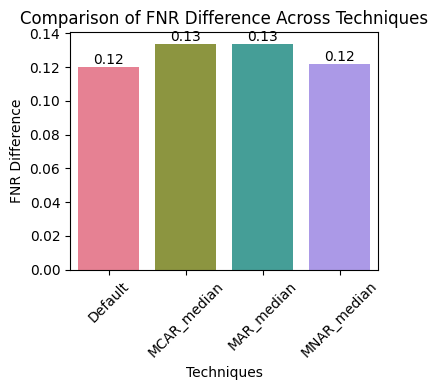

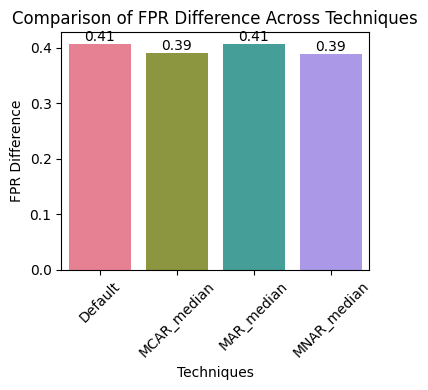

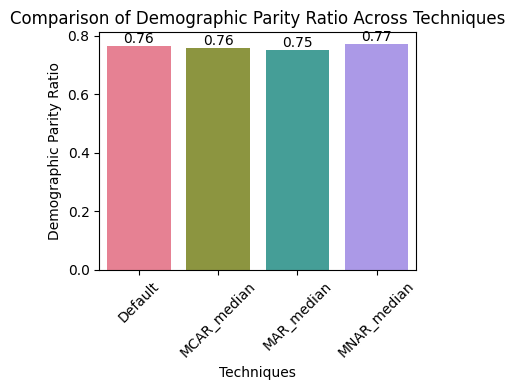

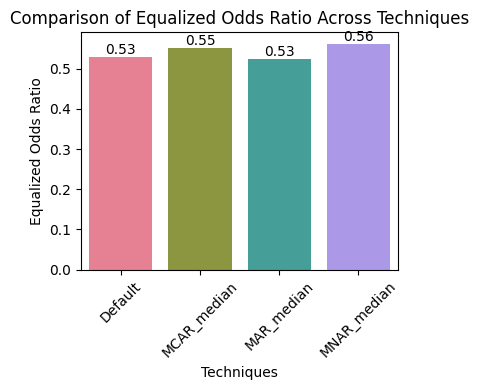

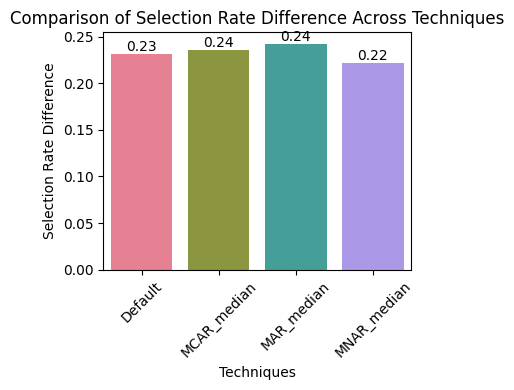

In [45]:
##MEDIAN FAIRNESS
# Combine data for each metric
fnr_diff_data = pd.DataFrame(fnr_diff_median, columns=["Technique", "FNR Difference"])
fpr_diff_data = pd.DataFrame(fpr_diff_median, columns=["Technique", "FPR Difference"])
dpr_data = pd.DataFrame(dpr_median, columns=["Technique", "Demographic Parity Ratio"])
eor_data = pd.DataFrame(eor_median, columns=["Technique", "Equalized Odds Ratio"])
srd_data = pd.DataFrame(srd_median, columns=["Technique", "Selection Rate Difference"])

dataframes = [fnr_diff_data, fpr_diff_data, dpr_data, eor_data, srd_data]
for df in dataframes:
    metric_name = df.columns[1]  # Second column holds metric values
    df[metric_name] = df[metric_name].apply(lambda x: float(x.iloc[0]) if hasattr(x, 'iloc') else float(x))

# Function to create bar plots for a given metric
def plot_metric(data, metric_name):
    plt.figure(figsize=(4, 4))
    # plt.bar(data["Technique"], data.iloc[:, 1], color=['blue', 'green', 'orange', 'red'])
    # plt.title(f"Comparison of {metric_name} Across Techniques")
    # plt.xlabel("Techniques")
    # plt.ylabel(metric_name)
    # plt.xticks(rotation=45)
    # plt.tight_layout()
    # plt.show()
    ax = sns.barplot(x="Technique", y=data.columns[1], data=data, palette="husl")

    # Add values above the bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # x-coordinate (center of bar)
            p.get_height(),         # y-coordinate (slightly above the bar)
            f'{p.get_height():.2f}',       # Value to display (formatted to 2 decimal places)
            ha="center",                   # Horizontal alignment
            va="bottom",                   # Vertical alignment
            fontsize=10                    # Font size of the annotation
        )

    plt.title(f"Comparison of {metric_name} Across Techniques")
    plt.xlabel("Techniques")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot all metrics
plot_metric(fnr_diff_data, "FNR Difference")
plot_metric(fpr_diff_data, "FPR Difference")
plot_metric(dpr_data, "Demographic Parity Ratio")
plot_metric(eor_data, "Equalized Odds Ratio")
plot_metric(srd_data, "Selection Rate Difference")

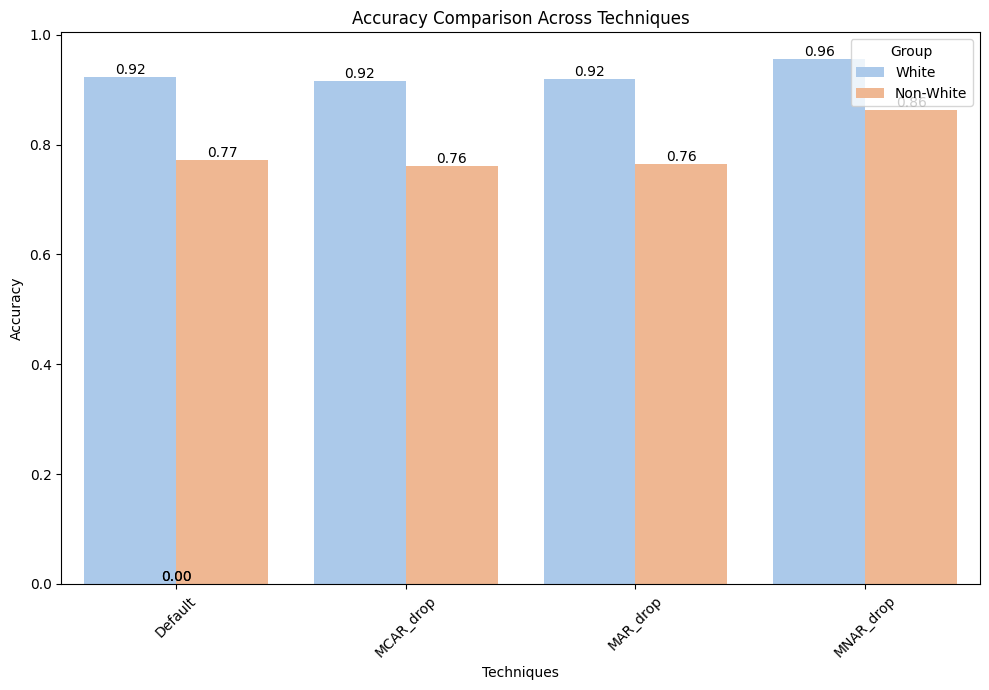

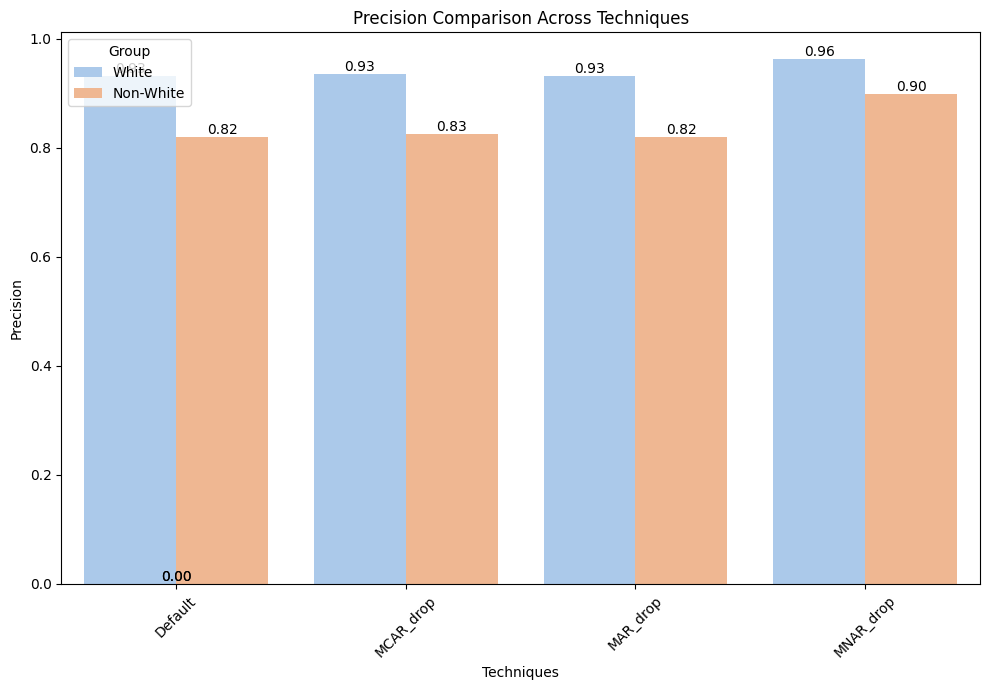

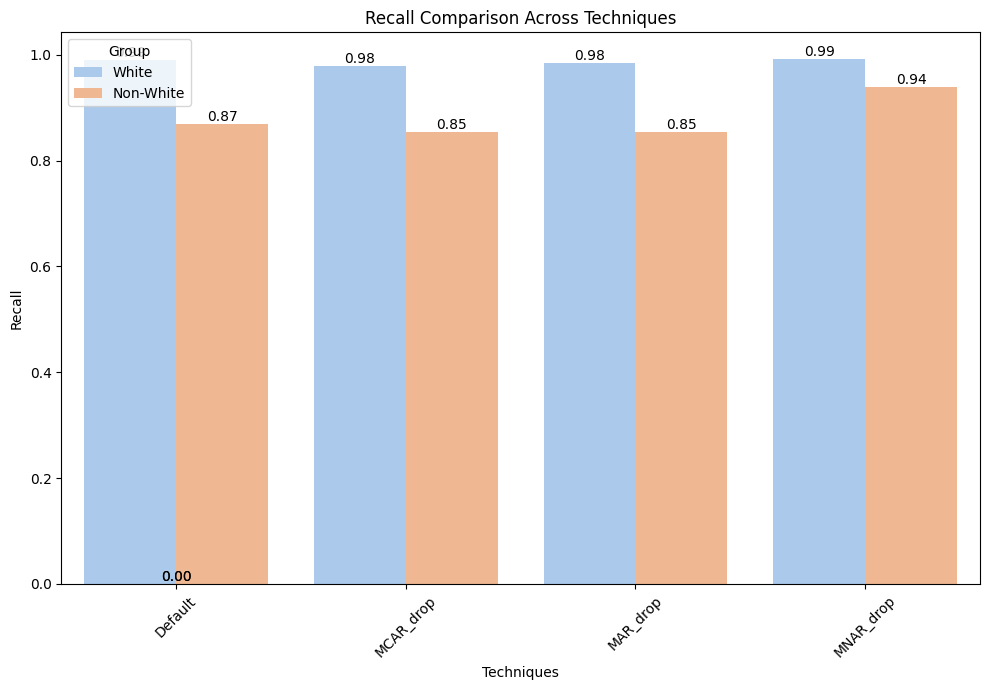

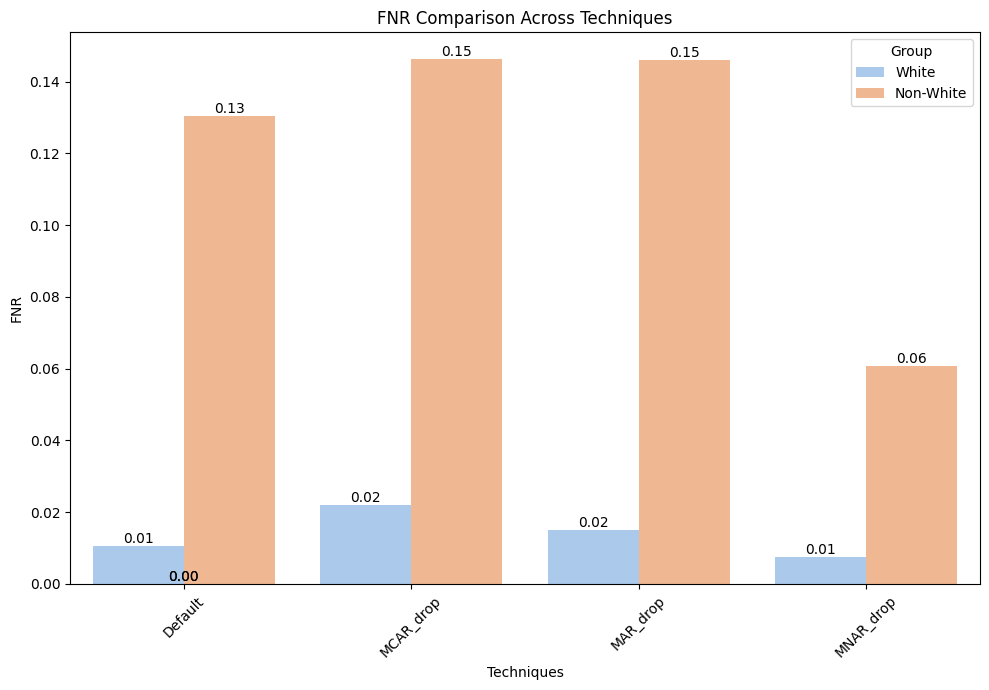

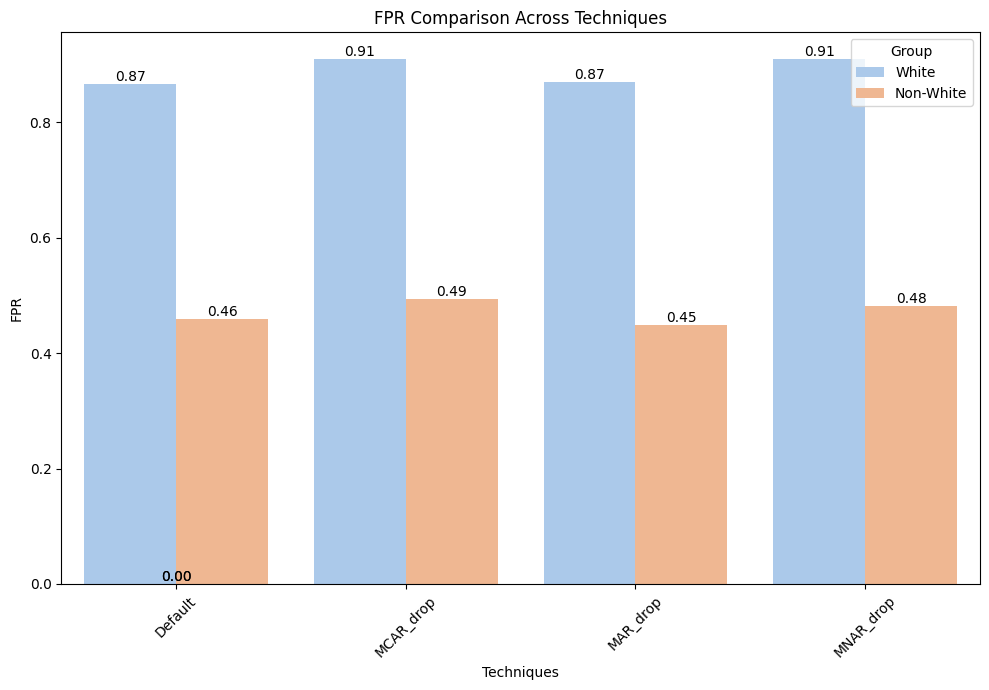

In [46]:
##DROP NULLS BY GROUP
# Example data transformation
dataframes = [acc_drop, prec_drop, rec_drop, fnr_drop, fpr_drop]
names = ["Accuracy", "Precision", "Recall", "FNR", "FPR"]

# Combine all metrics into a long-form DataFrame
all_data = []
for metric_name, metric_data in zip(names, dataframes):
    for item in metric_data:
        technique = item[0]
        white = item[1][0]
        non_white = item[1][1]
        all_data.append({"Metric": metric_name, "Technique": technique, "Group": "White", "Value": white})
        all_data.append({"Metric": metric_name, "Technique": technique, "Group": "Non-White", "Value": non_white})

metrics_df = pd.DataFrame(all_data)
# print(metrics_df)


# Plot grouped bar charts for each metric
for metric_name in metrics_df["Metric"].unique():
    metric_data = metrics_df[metrics_df["Metric"] == metric_name]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(data=metric_data, x="Technique", y="Value", hue="Group", palette="pastel")

    # Add values above the bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # Center of bar
            p.get_height(),         # Slightly above the bar
            f"{p.get_height():.2f}",       # Format value to 2 decimal places
            ha="center", va="bottom", fontsize=10
        )

    # Add titles and labels
    plt.title(f"{metric_name} Comparison Across Techniques")
    plt.xlabel("Techniques")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()


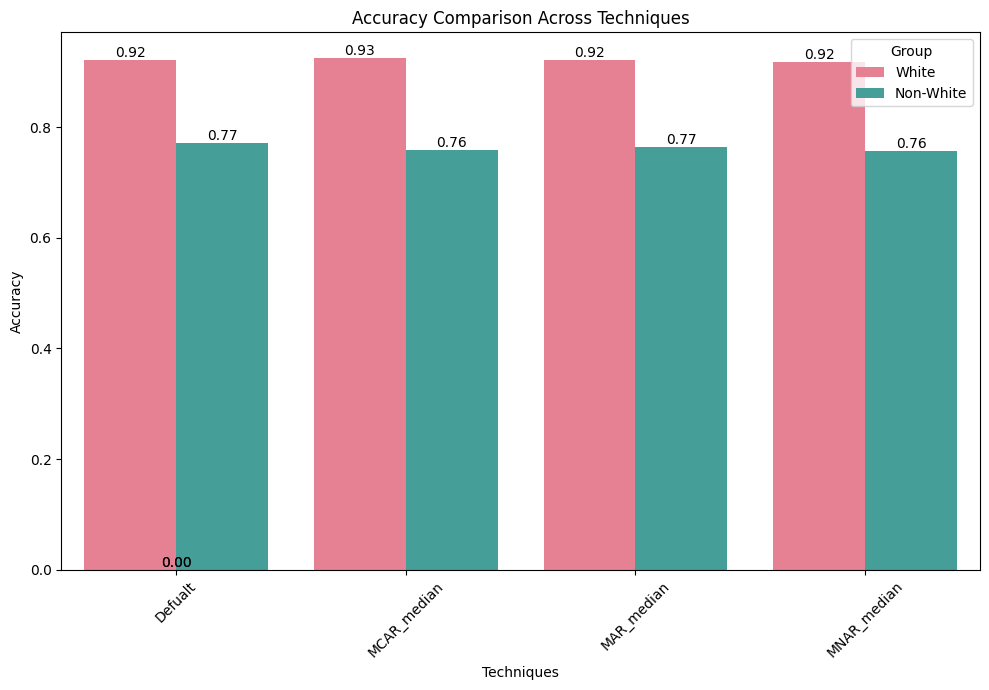

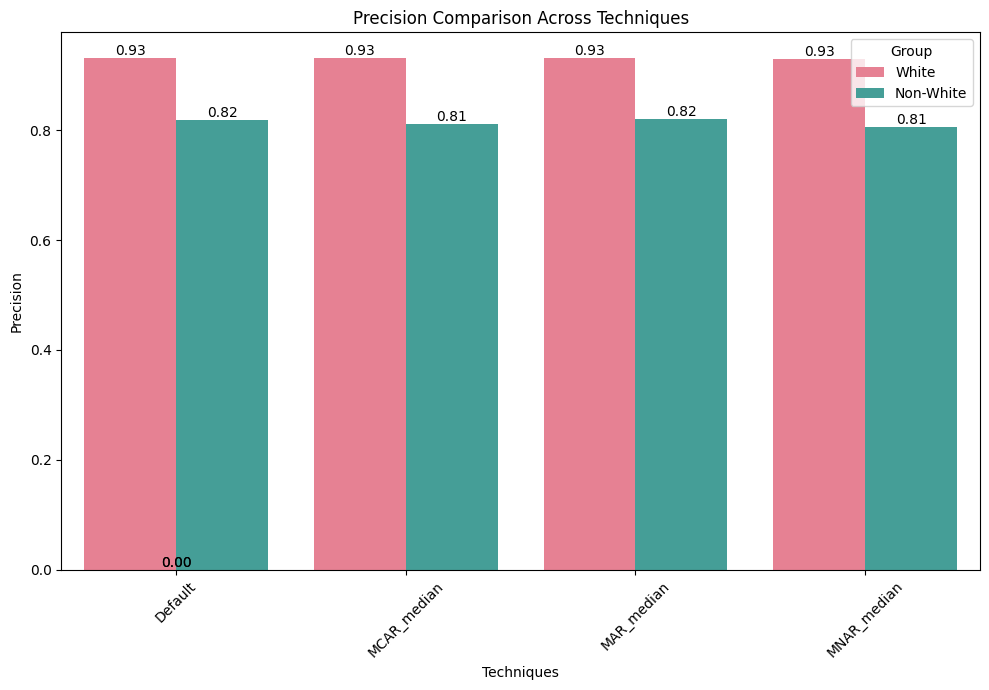

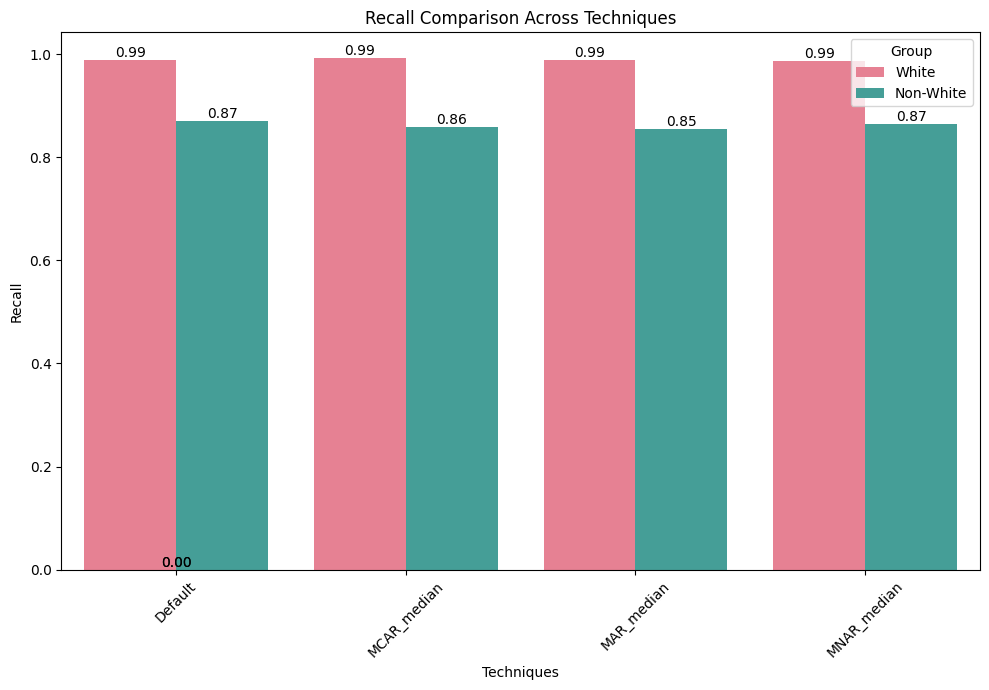

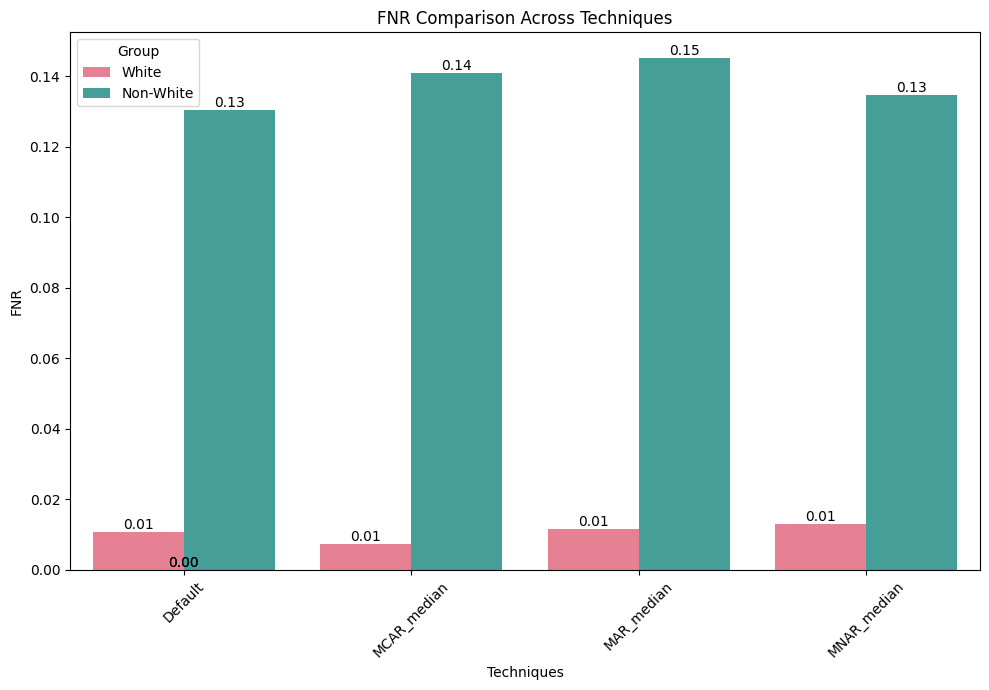

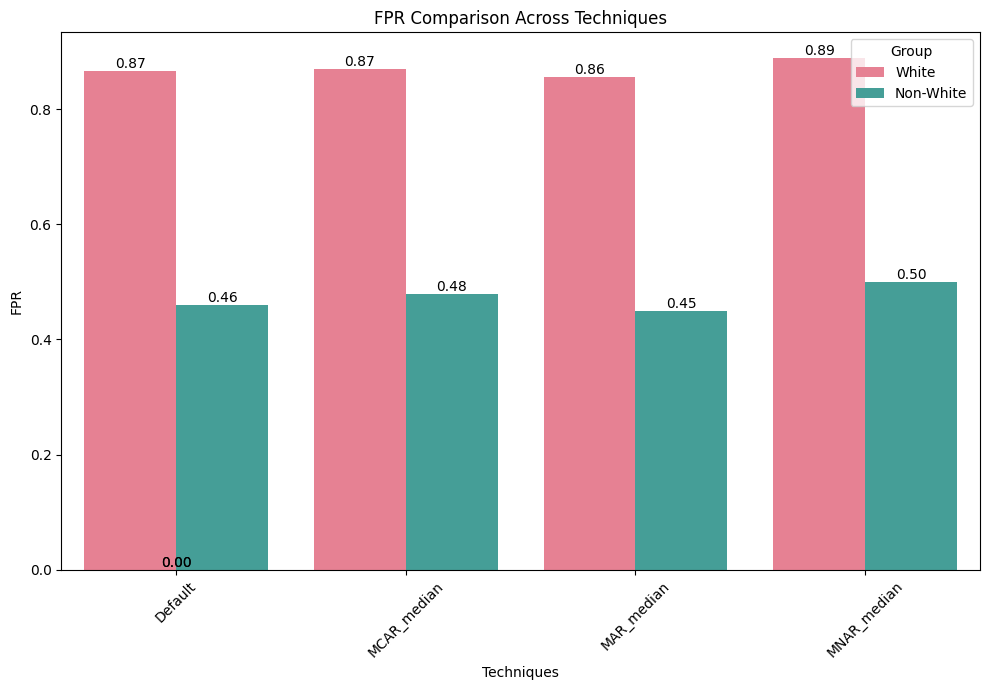

In [47]:
##MEDIAN BY GROUP
# Example data transformation
dataframes = [acc_median, prec_median, rec_median, fnr_median, fpr_median]
names = ["Accuracy", "Precision", "Recall", "FNR", "FPR"]

# Combine all metrics into a long-form DataFrame
all_data = []
for metric_name, metric_data in zip(names, dataframes):
    for item in metric_data:
        technique = item[0]
        white = item[1][0]
        non_white = item[1][1]
        all_data.append({"Metric": metric_name, "Technique": technique, "Group": "White", "Value": white})
        all_data.append({"Metric": metric_name, "Technique": technique, "Group": "Non-White", "Value": non_white})

metrics_df = pd.DataFrame(all_data)
# print(metrics_df)


# Plot grouped bar charts for each metric
for metric_name in metrics_df["Metric"].unique():
    metric_data = metrics_df[metrics_df["Metric"] == metric_name]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(data=metric_data, x="Technique", y="Value", hue="Group", palette="husl")

    # Add values above the bars
    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width() / 2,  # Center of bar
            p.get_height(),         # Slightly above the bar
            f"{p.get_height():.2f}",       # Format value to 2 decimal places
            ha="center", va="bottom", fontsize=10
        )

    # Add titles and labels
    plt.title(f"{metric_name} Comparison Across Techniques")
    plt.xlabel("Techniques")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45)
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()


## Extra Credit: D-Hacking

(Extra Credit) As argued in [this](https://dl.acm.org/doi/pdf/10.1145/3630106.3658928) paper. It's possible to build models that are fair according to a particular fairness constraint, but even minor perturbations in the model (changing the random state) or data parameters (test-train split) can significantly affect fairness metric values.

In this question, implement a multi-layer perceptron (you can use Sklearn's implementation from [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)) and run it five times while varying:

*   random_state
*   Test-train split of the data

Create a boxplot showing the variation of each fairness metric for white and non-white individuals. Does changing the parameters above cause variation in the fairness metric values? Do the changes affect each fairness metrics differently? Comment.






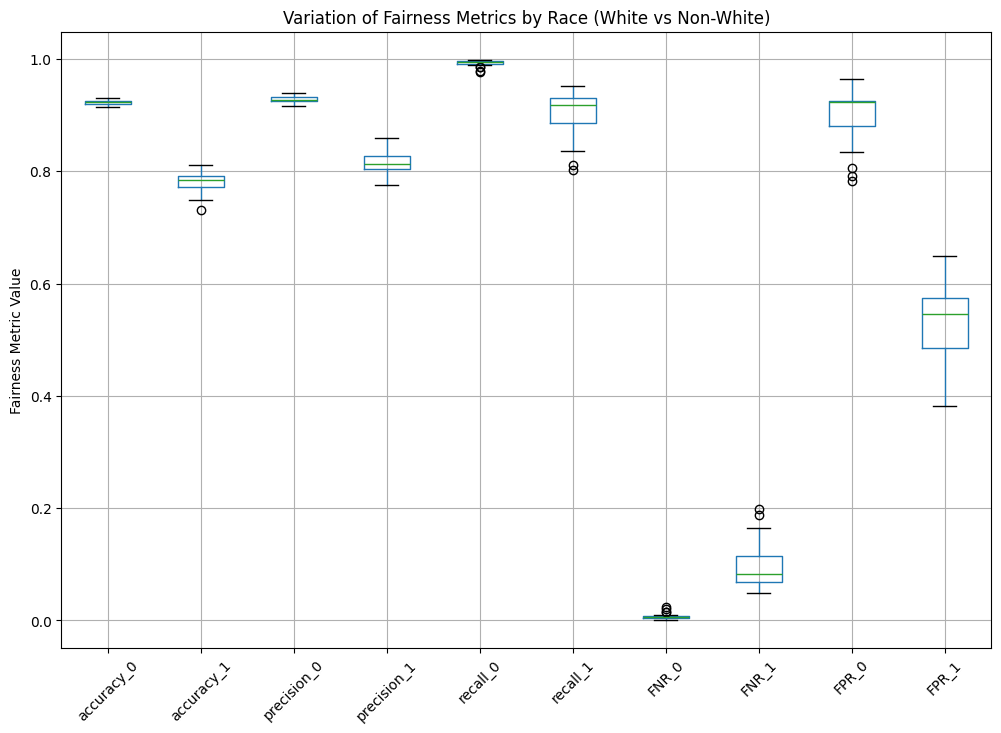

In [68]:
#@markdown TODO: train a model (with much higher variance, such as MLP) and evaluate fairness metrics (do not repeat Random Forest unless you fine-tune)

from sklearn.neural_network import MLPClassifier


# Parameters for experimentation
random_states = [0, 10, 24, 42, 60]
split_ratios = [0.1, 0.2, 0.25, 0.35, 0.45]

# Initialize lists to store fairness metrics for each combination of parameters
results = {metric: [] for metric in ['accuracy_0', 'accuracy_1',
                                     'precision_0', 'precision_1',
                                     'recall_0', 'recall_1',
                                     'FNR_0', 'FNR_1',
                                     'FPR_0', 'FPR_1']}

metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'FNR': false_negative_rate,
    'FPR': false_positive_rate,
}

# Running the experiment
for random_state in random_states:
    for split_ratio in split_ratios:
        # Prepare data using the prepare_data function
        df_copy = df.copy()  # Creating a copy to avoid modifying the original dataframe
        X_train, X_test, y_train, y_test = prepare_data(df_copy, test_size=split_ratio, seed=random_state)

        # Extract the sensitive feature (race) from X_test
        race = X_test['Non-White']

        # Train the MLP model
        model = MLPClassifier(random_state=random_state)
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Calculate fairness metrics using MetricFrame
        groupby_race = MetricFrame(metrics=metrics,
                                   y_true=y_test,
                                   y_pred=y_pred,
                                   sensitive_features=race)

        # Storing results for each fairness metric
        for metric_name, metric_values in groupby_race.by_group.items():
            for group_value, metric_value in metric_values.items():
                # For each metric, append both the group value (0 or 1) and the corresponding metric value
                results[f"{metric_name}_{group_value}"].append(metric_value)

# Convert results to DataFrame for easier plotting
metrics_df = pd.DataFrame(results)

# Plotting the boxplot for fairness metrics across race (White vs Non-White)
plt.figure(figsize=(12, 8))
metrics_df.boxplot()
plt.title("Variation of Fairness Metrics by Race (White vs Non-White)")
plt.ylabel("Fairness Metric Value")
plt.xticks(rotation=45)
plt.show()

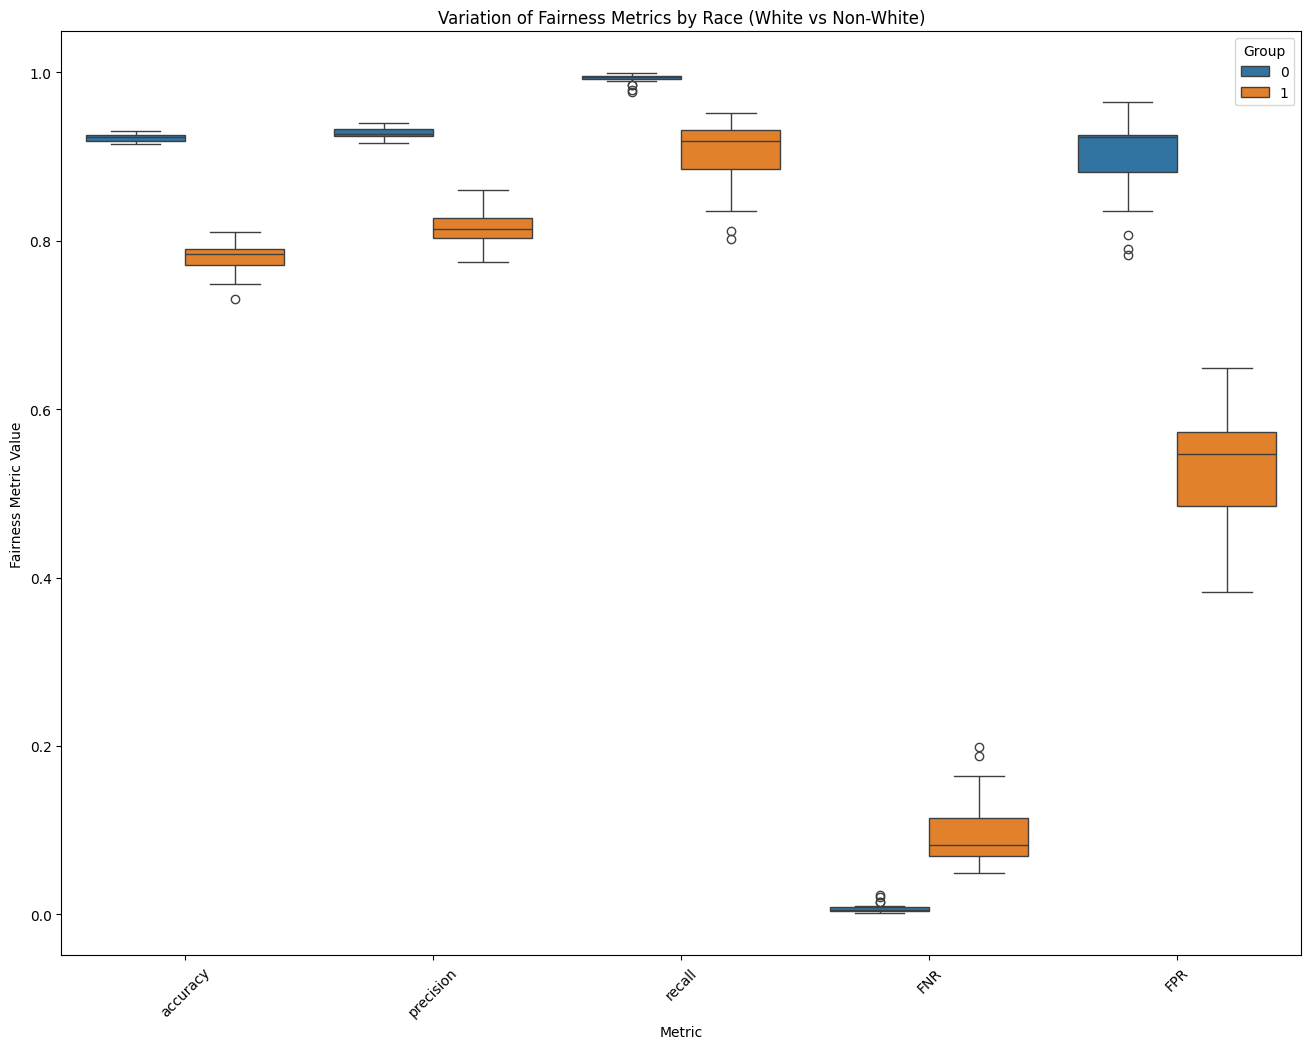

In [89]:
##@markdown TODO: Create boxplots to show variation in fairness metrics from just changing test-train splits/random seeds.

import seaborn as sns

# for use with Seaborn
metrics_df_long = pd.melt(metrics_df,
                          var_name='Metric_Group',
                          value_name='Metric_Value')

metrics_df_long[['Metric', 'Group']] = metrics_df_long['Metric_Group'].str.split('_', expand=True)

# Plotting with Seaborn boxplot
plt.figure(figsize=(16, 12))
sns.boxplot(x='Metric', y='Metric_Value', hue='Group', data=metrics_df_long, notch=False)
plt.title("Variation of Fairness Metrics by Race (White vs Non-White)")
plt.ylabel("Fairness Metric Value")
plt.xticks(rotation=45)
plt.show()


In [73]:


# # Plotting the boxplot
# plt.figure(figsize=(12, 8))
# metrics_df_fair.boxplot()
# plt.title("Fairness Metrics Across Different Random States and Split Ratios")
# plt.ylabel("Fairness Metric Value")
# plt.xticks(rotation=45)
# plt.show()